# Extract Parameters

Process the synthetic files and extract equivalent circuit model parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.append('../')

from src import fit as fit
from src import plotter as plotter
plotter.initialize(plt)

%load_ext autoreload
%autoreload 2

## Open Circuit Voltage

Use the pseudo-OCV test to extract the OCV curve and the nominal (OCV) cell capacity

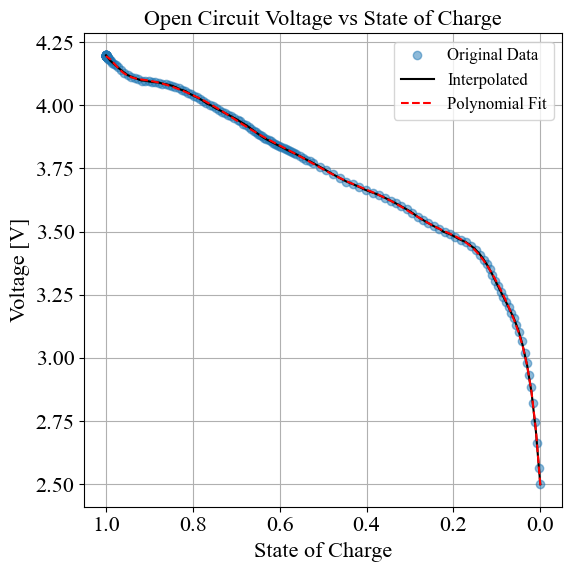

In [2]:
df = pd.read_csv('../output/synthetic_data/characterization_test_ocv_0.01C.csv')

soc = 1 - df['Capacity [Ah]']/df['Capacity [Ah]'].max()
voltage = df['Voltage [V]']

# Flip the vectors so that they start at 0% SOC
soc = soc[::-1]
voltage = voltage[::-1]

# Create evenly spaced SOC points for interpolation
# First remove any duplicate SOC values to ensure monotonic interpolation
soc_interp = np.linspace(0, 1, 100)
voltage_interp = np.interp(soc_interp, soc, voltage)

# Fit a polynomial
poly_order = 15
coef_fit = np.polyfit(soc_interp, voltage_interp, poly_order)
voltage_fit = np.polyval(coef_fit, soc_interp)

# Save interpolated data to CSV
ocv_data = pd.DataFrame({
    'SOC': soc_interp,
    'Voltage [V]': voltage_interp
})
ocv_data.to_csv('../output/parameters/ocv_lookup.csv', index=False)

# Save the polynomial coefficients
coef_df = pd.DataFrame({
    'order': range(len(coef_fit)-1, -1, -1),
    'coefficient': coef_fit
})
coef_df.to_csv('../output/parameters/ocv_poly_coefficients.csv', index=False)

# Create a dataframe with the capacity value
capacity_df = pd.DataFrame({
    'Capacity [Ah]': [df['Capacity [Ah]'].max()]
})
capacity_df.to_csv('../output/parameters/ocv_capacity.csv', index=False)

# Define a lookup function that maps voltage to SOC and vice versa
lookup_ocv_to_soc = lambda v: np.interp(v, voltage_interp, soc_interp)
lookup_soc_to_ocv = lambda s: np.interp(s, soc_interp, voltage_interp)

# Plot original and interpolated data
plt.figure()
plt.plot(soc, voltage, 'o', alpha=0.5, label='Original Data')
plt.plot(soc_interp, voltage_interp, 'k-', label='Interpolated')
plt.plot(soc_interp, voltage_fit, 'r--', label='Polynomial Fit')
plt.gca().invert_xaxis()
plt.xlabel('State of Charge')
plt.ylabel('Voltage [V]')
plt.grid(True)
plt.legend(fontsize=12)
plt.title('Open Circuit Voltage vs State of Charge')

plt.tight_layout()
plt.savefig('../output/figs/ocv_interpolated.png', dpi=150)

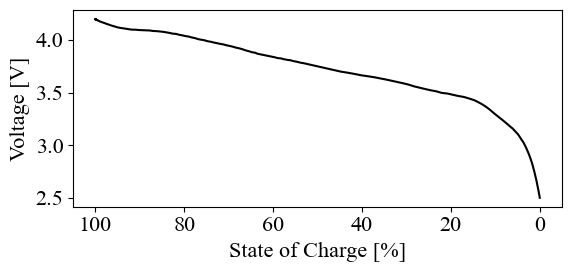

In [61]:
# Plot original and interpolated data
plt.figure(figsize=(6,3))
plt.plot(soc*100, voltage, c='k')
plt.gca().invert_xaxis()
plt.xlabel('State of Charge [%]')
plt.ylabel('Voltage [V]')
plt.grid(False)

plt.tight_layout()
plt.savefig('../output/figs/ocv_interpolated.png', dpi=150)

## Process the HPPC data

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_55214/2222981307.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


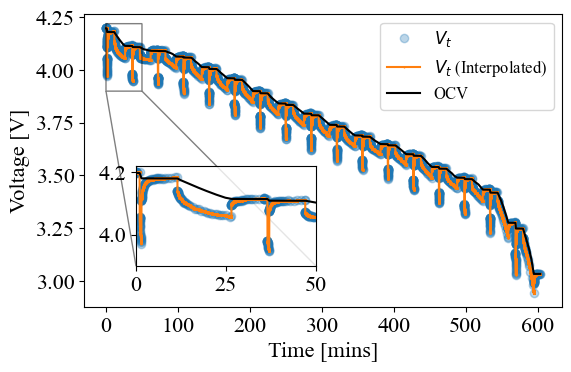

In [83]:
df = pd.read_csv('../output/synthetic_data/characterization_test_hppc_1.0C.csv')

df['SOC'] = 1 - df['Capacity [Ah]']/df['Capacity [Ah]'].max()

# Get the last voltage measurement and find corresponding SOC
final_voltage = df['Voltage [V]'].iloc[-1]
final_soc = lookup_ocv_to_soc(final_voltage)

# Scale SOC to span between final_soc and 1
df['SOC'] = final_soc + (1 - final_soc) * df['SOC']

# Sample the data along an evenly spaced time vector
dt = 0.1
time_s2 = np.arange(0, df['Time [s]'].max() + dt, dt)
voltage_interp2 = np.interp(time_s2, df['Time [s]'], df['Voltage [V]'])
current_interp2 = np.interp(time_s2, df['Time [s]'], df['Current [A]'])
power_interp2 = np.interp(time_s2, df['Time [s]'], df['Power [W]'])
capacity_interp2 = np.interp(time_s2, df['Time [s]'], df['Capacity [Ah]'])
energy_interp2 = np.interp(time_s2, df['Time [s]'], df['Energy [Wh]'])
soc_interp2 = np.interp(time_s2, df['Time [s]'], df['SOC'])
ocv_interp2 = lookup_soc_to_ocv(soc_interp2)

# Create a new dataframe with interpolated values
df_interp = pd.DataFrame({
    'Time [s]': time_s2,
    'Current [A]': current_interp2,
    'Power [W]': power_interp2,
    'Voltage [V]': voltage_interp2,
    'Capacity [Ah]': capacity_interp2,
    'Energy [Wh]': energy_interp2,
    'SOC': soc_interp2,
    'OCV [V]': ocv_interp2
})

plt.figure(figsize=(6,4))
ax = plt.gca()
ax.plot(df['Time [s]']/60, df['Voltage [V]'], 'o', alpha=0.3, label=r'$V_t$')
ax.plot(time_s2/60, voltage_interp2, 'o-', markersize=0.4, label=r'$V_t$ (Interpolated)')
ax.plot(time_s2/60, ocv_interp2, '-', markersize=0.4, c='k', label=r'OCV')
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Voltage [V]')
ax.legend(fontsize=12)
ax.grid(False)

# Add inset plot
axins = plt.axes([0.25, 0.30, 0.3, 0.25])
axins.plot(df['Time [s]']/60, df['Voltage [V]'], 'o', alpha=0.3, label=r'$V_t$')
axins.plot(time_s2/60, voltage_interp2, 'o-', markersize=0.4, label=r'$V_t$ (Interpolated)')
axins.plot(time_s2/60, ocv_interp2, '-', markersize=0.4, c='k', label=r'OCV')
axins.set_xlim(0, 50)
axins.set_ylim(3.90, 4.22)
axins.grid(False)
axins.patch.set_alpha(0.8)

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.savefig('../output/figs/hppc_interpolation_2.png', dpi=150)

# Use the simple method to extract Rs

In [4]:
def one_pole_digital_filter(x, alpha):

    y = np.zeros_like(x)

    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = (1 - alpha) * x[i] + alpha * y[i-1]

    return y


## Use Least Squares to extract Rs, R1, and C1

/Users/aweng/code/battery-digital-twin-from-scratch/notebooks/../src/fit.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  C1 = dt / (b0 - a0*b1)
/Users/aweng/code/battery-digital-twin-from-scratch/notebooks/../src/fit.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  R1 = (b0 - a0*b1) / (a0+1)


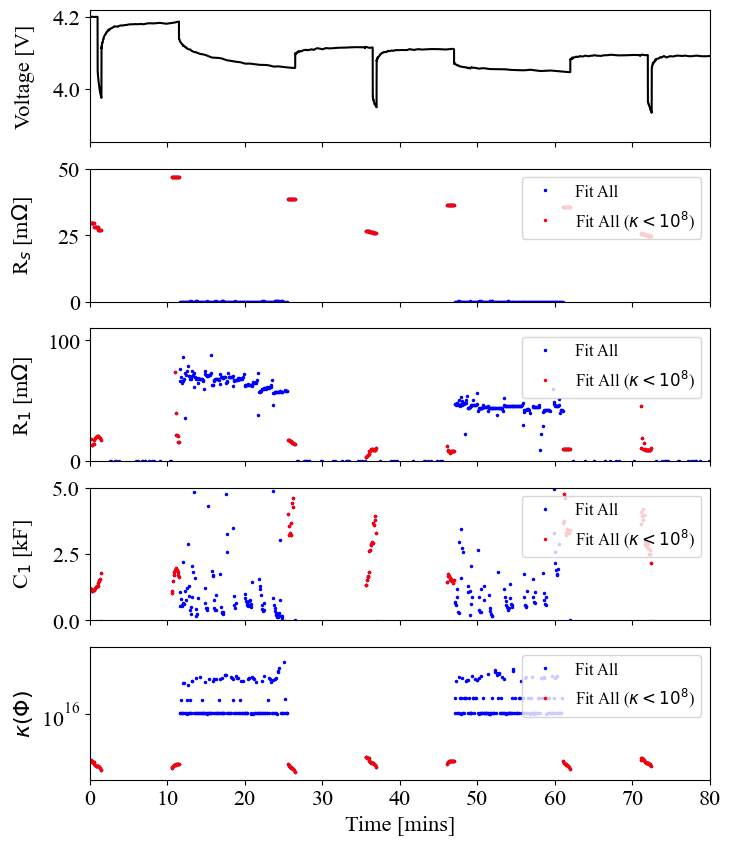

In [5]:
time_horizon_s = 60 # seconds
update_frequency_s = 5 # seconds

# Calculate number of samples in each window
window_samples = int(time_horizon_s / dt)

# Initialize variables specifically for storing parameter estimates
# These variables will have different dimensions based on the update frequency
# and the time horizon
time_params_s = []
soc_param = []
current_param = []

for i in range(len(df_interp)):

    if (i * dt) % update_frequency_s != 0:
        continue

    if i + window_samples > len(df_interp):
        break

    # Get window of data
    voltage_window = df_interp['Voltage [V]'].iloc[i:i+window_samples]
    current_window = df_interp['Current [A]'].iloc[i:i+window_samples]
    ocv_window     = df_interp['OCV [V]'].iloc[i:i+window_samples]

    # Call least squares on the window
    rs, r1, c1, cond_num = fit.least_squares(voltage_window,
                                             -current_window, ocv_window, dt)

    if len(time_params_s) == 0:
        params_mat = np.array([rs, r1, c1, cond_num])
    else:
        params_mat = np.vstack((params_mat, [rs, r1, c1, cond_num]))

    time_params_s.append(i * dt)
    soc_param.append(df_interp['SOC'].iloc[i])
    current_param.append(df_interp['Current [A]'].iloc[i])

time_params_s = np.array(time_params_s)
soc_param = np.array(soc_param)
current_param = np.array(current_param)

good_indices = params_mat[:, 3] < 1e8
filtered_time = time_params_s[good_indices]
filtered_soc = soc_param[good_indices]
filtered_params = params_mat[good_indices]

# See what the data looks like before any filtering based on condition number
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1,
                                              figsize=(8, 10), sharex=True)
plt.subplots_adjust(hspace=0.2)

[ax.grid(False) for ax in fig.axes]

msz = 1.5

# Plot voltage vs time
ax0.plot(time_s2/60, df_interp['Voltage [V]'], c='k')
ax0.set_ylabel('Voltage [V]')
ax0.set_ylim((3.85, 4.22))

# Plot Rs
ax1.plot(time_params_s/60, params_mat[:, 0]*1e3, 'o', c='b', markersize=msz, label='Fit All')
ax1.plot(filtered_time/60, filtered_params[:, 0]*1e3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax1.set_ylabel(r'R$_s$ [m$\Omega$]')
ax1.set_ylim((0,50))
ax1.legend(fontsize=12, loc='upper right')

# Plot R1
ax2.plot(time_params_s/60, params_mat[:, 1]*1e3, 'o', c='b', markersize=msz, label='Fit All')
ax2.plot(filtered_time/60, filtered_params[:, 1]*1e3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax2.set_ylabel(r'R$_1$ [m$\Omega$]')
ax2.set_ylim((0,110))
ax2.legend(fontsize=12, loc='upper right')

# Plot C1
ax3.plot(time_params_s/60, params_mat[:, 2]*1e-3, 'o', c='b', markersize=msz, label='Fit All')
ax3.plot(filtered_time/60, filtered_params[:, 2]*1e-3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax3.set_ylabel(r'C$_1$ [kF]')
ax3.set_ylim((0,5))
ax3.legend(fontsize=12, loc='upper right')

# Plot condition number
ax4.semilogy(time_params_s/60, params_mat[:, 3], 'o', c='b', markersize=msz, label='Fit All')
ax4.semilogy(filtered_time/60, filtered_params[:, 3], 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax4.set_ylabel(r'$\kappa(\Phi)$')
ax4.set_xlabel('Time [mins]')
ax4.legend(fontsize=12, loc='upper right')

fig.align_ylabels()

ax4.set_xlim((0, 80))

plt.savefig('../output/figs/hppc_parameter_estimation_1_zoom.png', dpi=150)

In [6]:
np.median(filtered_params[:, 0])

0.02942611933061126

## Re-parameterize using only the pulse data

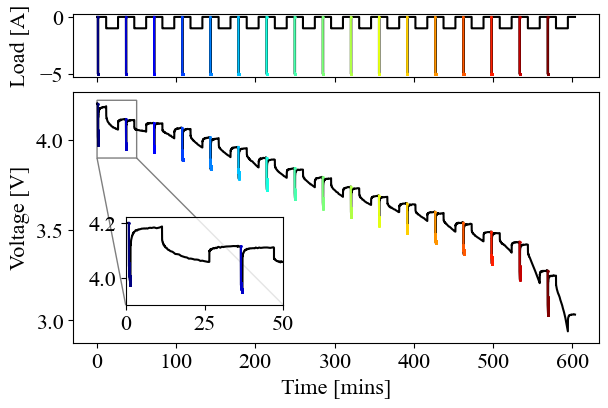

In [73]:

# Plot original vs interpolated data
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(6,4),
                               height_ratios=[1, 4])
[ax.grid(False) for ax in fig.axes]

# Plot current vs time
ax1.plot(df['Time [s]']/60, -df['Current [A]'], c='k')
ax1.set_xticklabels([])
ax1.set_ylabel('Load [A]')

# Plot voltage data
ax2.plot(df['Time [s]']/60, df['Voltage [V]'], c='k', label=r'$V_t$')
ax2.set_xlabel('Time [mins]')
ax2.set_ylabel('Voltage [V]')

# Add inset plot
axins = ax2.inset_axes([0.10, 0.15, 0.3, 0.35])
axins.plot(df['Time [s]']/60, df['Voltage [V]'], c='k', label=r'$V_t$')
axins.set_xlim(0, 50)
axins.set_ylim(3.90, 4.22)
axins.grid(False)


# Let's try to find the parameters another way. Extract each pulse explicitly and focus on fitting to just the pulse data.
time_s = df_interp['Time [s]']
current_a = df_interp['Current [A]']
voltage_v = df_interp['Voltage [V]']

# Find indices where current transitions from 0A to >4A
pulse_indices = []
for i in range(1, len(current_a)):
    if current_a[i-1] == 0 and current_a[i] > 4:
        pulse_indices.append(i)

# Initialize lists to store pulse data
pulses_data = []

for idx in pulse_indices:

    # Get data from just before pulse starts
    # Find end of pulse (when current returns to 0)
    start_idx = idx - 1
    end_idx = start_idx + 1

    while end_idx < len(current_a) and current_a[end_idx] > 4:
        end_idx += 1

    # Extract data for this pulse
    pulse_data = {
        'time': time_s[start_idx:end_idx],
        'voltage': voltage_v[start_idx:end_idx],
        'current': current_a[start_idx:end_idx],
        'soc': df_interp['SOC'][start_idx],  # SOC at start of pulse
        'ocv': voltage_v[start_idx],
        'start_idx': start_idx,
        'end_idx': end_idx,
    }
    pulses_data.append(pulse_data)

    # Calculate dt from the time data
    dt = pulse_data['time'].iloc[1] - pulse_data['time'].iloc[0]

    # Fit the pulse data
    rs, r1, c1, cond_num = fit.least_squares(
                            pulse_data['voltage'],
                        -pulse_data['current'],
                        pulse_data['ocv'], dt
                        )

    # Store results in pulse_data
    pulse_data['Rs'] = rs
    pulse_data['R1'] = r1
    pulse_data['C1'] = c1
    pulse_data['condition_number'] = cond_num

# Plot all pulses
colors = plt.cm.jet(np.linspace(0, 1, len(pulses_data)))
for i, pulse_data in enumerate(pulses_data):
    ax1.plot(pulse_data['time']/60, -pulse_data['current'], 'o-', c=colors[i], markersize=1)
    ax2.plot(pulse_data['time']/60, pulse_data['voltage'], 'o-', c=colors[i], markersize=1,
                label=f'Pulse {i+1} (SOC={pulse_data["soc"]:.2f})')
    axins.plot(pulse_data['time']/60, pulse_data['voltage'], 'o-', c=colors[i], markersize=1,
                label=f'Pulse {i+1} (SOC={pulse_data["soc"]:.2f})')


axins.patch.set_alpha(0.8)
ax2.indicate_inset_zoom(axins, edgecolor="black")
fig.align_ylabels([ax1, ax2])
plt.tight_layout(pad=0.25)
plt.savefig('../output/figs/hppc_interpolation_1.png', dpi=150)

Found 17 pulses at following time points (minutes):
t = 1.0 min, Duration: 30.0 s
t = 36.5 min, Duration: 30.0 s
t = 72.0 min, Duration: 30.0 s
t = 107.5 min, Duration: 30.0 s
t = 143.0 min, Duration: 30.0 s
t = 178.5 min, Duration: 30.0 s
t = 214.0 min, Duration: 30.0 s
t = 249.5 min, Duration: 30.0 s
t = 285.0 min, Duration: 30.0 s
t = 320.5 min, Duration: 30.0 s
t = 356.0 min, Duration: 30.0 s
t = 391.5 min, Duration: 30.0 s
t = 427.0 min, Duration: 30.0 s
t = 462.5 min, Duration: 30.0 s
t = 498.0 min, Duration: 30.0 s
t = 533.5 min, Duration: 30.0 s
t = 569.0 min, Duration: 30.0 s

Extracted 17 pulses


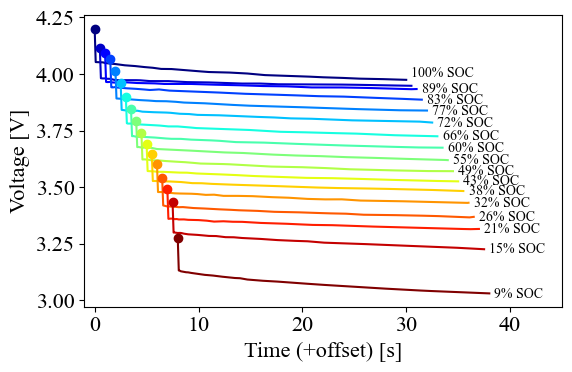

In [ ]:
# Let's try to find the parameters another way. Extract each pulse explicitly and focus on fitting to just the pulse data.
time_s = df_interp['Time [s]']
current_a = df_interp['Current [A]']
voltage_v = df_interp['Voltage [V]']

# Find indices where current transitions from 0A to >4A
pulse_indices = []
for i in range(1, len(current_a)):
    if current_a[i-1] == 0 and current_a[i] > 4:
        pulse_indices.append(i)

# Print time points where pulses occur
print(f"Found {len(pulse_indices)} pulses at following time points (minutes):")

# Initialize lists to store pulse data
pulses_data = []

for idx in pulse_indices:

    # Get data from just before pulse starts
    # Find end of pulse (when current returns to 0)
    start_idx = idx - 1
    end_idx = start_idx + 1

    while end_idx < len(current_a) and current_a[end_idx] > 4:
        end_idx += 1

    # Extract data for this pulse
    pulse_data = {
        'time': time_s[start_idx:end_idx] - time_s[start_idx:end_idx].iloc[0],
        'voltage': voltage_v[start_idx:end_idx],
        'current': current_a[start_idx:end_idx],
        'soc': df_interp['SOC'][start_idx],  # SOC at start of pulse
        'ocv': voltage_v[start_idx],
        'start_idx': start_idx,
        'end_idx': end_idx,
    }
    pulses_data.append(pulse_data)

    # Calculate dt from the time data
    dt = pulse_data['time'].iloc[1] - pulse_data['time'].iloc[0]

    # Fit the pulse data
    rs, r1, c1, cond_num = fit.least_squares(
                            pulse_data['voltage'],
                        -pulse_data['current'],
                        pulse_data['ocv'], dt
                        )

    # Store results in pulse_data
    pulse_data['Rs'] = rs
    pulse_data['R1'] = r1
    pulse_data['C1'] = c1
    pulse_data['condition_number'] = cond_num

    # Print summary
    print(f"t = {time_s[idx]/60:.1f} min, Duration: {pulse_data['time'].iloc[-1] - pulse_data['time'].iloc[0]:.1f} s")

print(f"\nExtracted {len(pulses_data)} pulses")

# Plot all pulses
plt.figure(figsize=(6, 4))
plt.gca().grid(False)
colors = plt.cm.jet(np.linspace(0, 1, len(pulses_data)))
for i, pulse_data in enumerate(pulses_data):
    plt.plot(pulse_data['time']+i/2, pulse_data['voltage'], c=colors[i],
                label=f'{pulse_data["soc"]*100:.0f}% SOC')
    plt.plot(pulse_data['time'].iloc[0]+i/2, pulse_data['voltage'].iloc[0], c=colors[i],
             marker='o', markersize=6, label='')

    soc_pct = f'{pulse_data["soc"]*100:.0f}% SOC'
    if i == 0:
        plt.text(pulse_data['time'].iloc[-1]+i/2+0.5, pulse_data['voltage'].iloc[-1]+0.03,
                soc_pct, color='k', fontsize=10, va='center')
    elif i == 1:
        pass
    else:
        plt.text(pulse_data['time'].iloc[-1]+i/2+0.5, pulse_data['voltage'].iloc[-1],
                soc_pct, color='k', fontsize=10, va='center')

plt.xlabel('Time (+offset) [s]')
plt.ylabel('Voltage [V]')
plt.xlim((-1, 45))
plt.tight_layout()

# Extract data from pulses_data for plotting
soc_vals = np.array([p['soc'] for p in pulses_data])
rs_vals = np.array([p['Rs'] for p in pulses_data])
r1_vals = np.array([p['R1'] for p in pulses_data])
c1_vals = np.array([p['C1'] for p in pulses_data])

plt.savefig('../output/figs/hppc_pulses_only.png', dpi=150)


In [29]:
colors[0]

array([0. , 0. , 0.5, 1. ])

# Use the simple method to calculate $R_s$

In [8]:
Vmeas = voltage_interp2
Imeas = current_interp2
den = Imeas[0:-2] - Imeas[1:-1]
num = Vmeas[1:-1] - Vmeas[0:-2]
idx = np.where(np.abs(den) > 0.1)[0]
tt = time_s2[idx]
ss = soc_interp2[idx]
R_simple = num[idx]/den[idx]
R_sim_filt = one_pole_digital_filter(R_simple, 0.01)

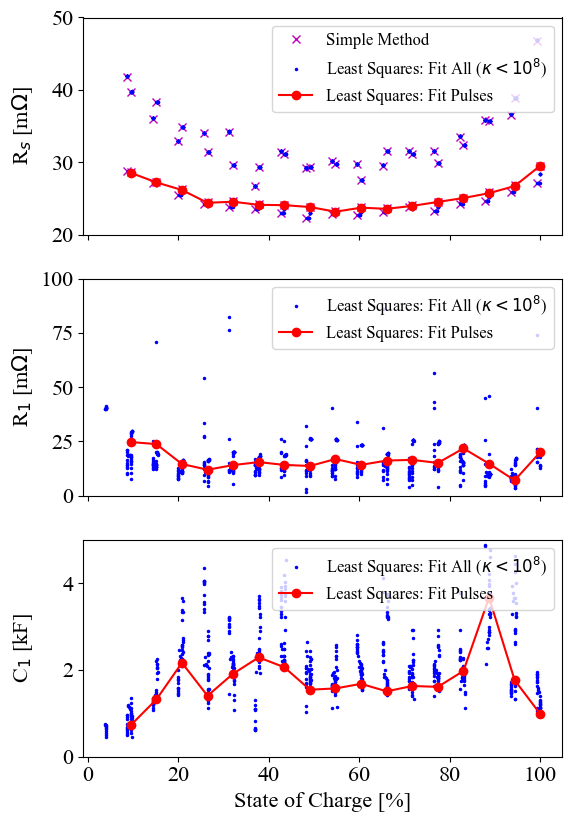

In [9]:
# Plot against SOC
# Create new figure with 5 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8.5), sharex=True)
plt.subplots_adjust(hspace=0.2)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

msz = 1.5

# Plot filtered Rs
ax1.plot(ss*100, R_sim_filt*1e3, 'x', c='m', label='Simple Method')
ax1.plot(filtered_soc*100, filtered_params[:, 0]*1e3, 'o', c='b',
         markersize=msz, label=r'Least Squares: Fit All ($\kappa < 10^8$)')

ax1.plot(soc_vals*100, rs_vals*1e3, 'o-', c='r', label='Least Squares: Fit Pulses')
ax1.set_ylabel(r'R$_s$ [m$\Omega$]')
ax1.set_ylim((20, 50))
ax1.legend(loc='upper right', fontsize=12)

# Plot filtered R1
ax2.plot(filtered_soc*100, filtered_params[:, 1]*1e3, 'o', c='b',
         markersize=msz, label=r'Least Squares: Fit All ($\kappa < 10^8$)')
ax2.plot(soc_vals*100, r1_vals*1e3, 'o-', c='r', label='Least Squares: Fit Pulses')
ax2.set_ylabel(r'R$_1$ [m$\Omega$]')
ax2.set_ylim((0,100))
ax2.legend(loc='upper right', fontsize=12)

# Plot filtered C1
ax3.plot(filtered_soc*100, filtered_params[:, 2]/1e3, 'o', c='b',
         markersize=msz, label=r'Least Squares: Fit All ($\kappa < 10^8$)')
ax3.plot(soc_vals*100, c1_vals/1e3, 'o-', c='r', label='Least Squares: Fit Pulses')
ax3.set_ylabel(r'C$_1$ [kF]')
ax3.set_ylim((0,5))
ax3.legend(loc='upper right', fontsize=12)

ax3.set_xlabel('State of Charge [%]')
fig.align_ylabels()

fig.tight_layout()
plt.savefig('../output/figs/hppc_parameter_estimation_2.png', dpi=150)

# Save the processed RC parameters

In [10]:
# Create dataframe from parameters
params_df = pd.DataFrame({
    'SOC': soc_vals[::-1],
    'Rs [Ohm]': rs_vals[::-1],
    'R1 [Ohm]': r1_vals[::-1],
    'C1 [F]': c1_vals[::-1]
})

# Save to CSV file
params_df.to_csv('../output/parameters/rc_parameters.csv', index=False)

In [11]:
params_df

,SOC,Rs [Ohm],R1 [Ohm],C1 [F]
0,0.094846,0.028535,0.024691,727.438969
1,0.151418,0.027210,0.023752,1318.193262
2,0.207990,0.026164,0.014569,2163.077692
3,0.264562,0.024388,0.011938,1403.563456
4,0.321134,0.024543,0.014079,1912.723118
5,0.377707,0.024105,0.015456,2288.079065
6,0.434279,0.024067,0.014158,2061.149777
7,0.490851,0.023807,0.013667,1544.085935
8,0.547423,0.023163,0.016866,1572.785376
9,0.603995,0.023717,0.014179,1679.006475


In [12]:
np.median(params_df['Rs [Ohm]']), np.median(params_df['R1 [Ohm]']), np.median(params_df['C1 [F]'])

(0.024511408161080214, 0.015073021088566984, 1629.3685326468521)